# SDB2 - Projeto de análise de dados de sinistros (PRF)

## Imports das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore') # somente para ignorar os warnings

## Leitura dos Dataframes

In [2]:
# Carrega os dados
sinistros_2024 = pd.read_csv('../bronze/data/acidentes2024_todas_causas_tipos.csv', sep=';', encoding='latin1', quotechar='"', low_memory=False)
sinistros_2025 = pd.read_csv('../bronze/data/acidentes2025_todas_causas_tipos.csv', sep=';', encoding='latin1', quotechar='"', low_memory=False)

# Verifique se as colunas são idênticas para garantir consistência
if sinistros_2024.columns.tolist() != sinistros_2025.columns.tolist():
    print("Aviso: As colunas dos dois datasets não são idênticas.")

## União dos dados de sinistro de 2024 e 2025 em um único Dataset

In [3]:
df = pd.concat([sinistros_2024, sinistros_2025], ignore_index=True)

# Tratamento do DataSet

## Remoção de colunas irrelevantes

In [4]:
cols_to_drop = [c for c in ['regional','uop','delegacia','classificacao_acidente', 'dia_semana', 'fase_dia'] if c in df.columns]
df.drop(cols_to_drop, axis=1, inplace=True)

## Tratamento das colunas

### Tratamento dos valores vazios e ajuste do separador decimal

In [5]:
# Função para normalizar strings
def normalize(s):
    # Transforma para string e remove espaços em branco
    s_str = s.astype(str).str.strip()
    # Trata valores vazios explícitos
    s = s_str.replace({'NaN':'', 'None':'', 'NoneType':'', '(null)':'', 'na':'', 'n/a':'', 'N/A':'', 'NULL':'', 'null':'', 'nan':''})
    # Troca vírgula decimal por ponto
    s = s.str.replace(',', '.', regex=False)
    s = s.replace('', pd.NA)
    return s

# Aplica normalização a todas as colunas
for col in df.columns.tolist():
    df[col] = normalize(df[col])

### Conversão das colunas tipo Int

In [6]:
int_cols = ['id','pesid','id_veiculo','idade','ano_fabricacao_veiculo','ordem_tipo_acidente','br','ilesos','feridos_leves','feridos_graves','mortos']
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c] = df[c].astype('Int64')

### Conversão das colunas tipo Float

In [7]:
float_cols = ['km','latitude','longitude']
for c in float_cols:
    if c in df.columns:
        df[c] = df[c].astype('Float64')

### Conversão das colunas tipo String

In [8]:
str_cols = ['dia_semana','uf','municipio','br','causa_principal','causa_acidente','tipo_acidente','fase_dia','sentido_via','condicao_metereologica','tipo_pista','tracado_via','uso_solo','veiculo_tipo','veiculo_marca_modelo','tipo_veiculo','estado_fisico','sexo']
for c in str_cols:
    if c in df.columns:
        df[c] = df[c].astype('string')

### Conversão da coluna tipo Datetime

In [9]:
df['data_inversa'] = pd.to_datetime(df['data_inversa'].astype(str).str.strip(), format='%Y-%m-%d', errors='coerce')

### Conversão das colunas tipo Time

In [10]:
s = df['horario'].astype(str).str.strip()
parsed = pd.to_datetime(s, format='%H:%M:%S', errors='coerce')
df['horario'] = parsed.dt.time

### Renomeio das colunas

In [ ]:
rename_map = {
    'ano_fabricacao_veiculo': 'veiculo_ano_fabricacao',
    'br': 'rodovia',
    'causa_acidente': 'sinistro_causa',
    'causa_principal': 'sinistro_causa_principal',
    'condicao_metereologica': 'condicao_meteorologica',
    'data_inversa': 'data',
    'estado_fisico': 'estado_fisico',
    'feridos_graves': 'feridos_graves',
    'feridos_leves': 'feridos_leves',
    'horario': 'horario',
    'id_veiculo': 'veiculo_id',
    'id': 'sinistro_id',
    'idade': 'envolvido_idade',
    'ilesos': 'ilesos',
    'km': 'quilometro',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'marca': 'veiculo_marca_modelo',
    'mortos': 'mortos',
    'municipio': 'municipio',
    'pesid': 'id_envolvido',
    'ordem_tipo_acidente': 'sinistro_ordem_tipo',
    'sentido_via': 'via_sentido',
    'sexo': 'envolvido_sexo',
    'tipo_acidente': 'sinistro_tipo',
    'tipo_envolvido': 'envolvido_tipo',
    'tipo_pista': 'via_tipo',
    'tipo_veiculo': 'veiculo_tipo',
    'tracado_via': 'via_tracado',
    'uf': 'uf',
    'uso_solo': 'uso_solo',
}
existing_renames = {k:v for k,v in rename_map.items() if k in df.columns}
if existing_renames:
    df.rename(columns=existing_renames, inplace=True)

## De - Para das colunas

### Conversão do uso do solo

In [12]:
# Substituições simples: uso_solo Sim/Não -> Urbano/Rural
df['uso_solo'] = df['uso_solo'].replace({'Sim':'Urbano','Não':'Rural'}).astype('string')

### Conversão da condição metereológica

In [ ]:
df['condicao_meteorologica'] = df['condicao_meteorologica'].replace({'Ceu':'Céu'})

## Criação de novas colunas

### Feridos

In [14]:
parts = []

# Somatória de feridos leves e graves (tratando NaNs)
parts.append(df['feridos_leves'].astype('Float64').fillna(0))
parts.append(df['feridos_graves'].astype('Float64').fillna(0))

df['feridos'] = sum(parts).astype('Int64')

### Rodovia

In [15]:
# Concatena 'BR-' com o número da rodovia, preenchendo com zero à esquerda se necessário
def mescla_rodovia(v):
    if pd.isna(v):
        return pd.NA
    s = str(v).strip()
    if len(s) < 3:
        return 'BR-0' + s
    return 'BR-' + s

df['rodovia'] = df['rodovia'].apply(mescla_rodovia).astype('string')

# Coluna NumRodovia extraída da coluna Rodovia
df['rodovia_numero'] = df['rodovia'].astype(str).str.split('-', n=1).str[-1]

### DataHora, DiaSemana, Ano, Hora

In [16]:

# Mapear dia da semana (segunda-feira ... domingo)
dias = {0:'Segunda-feira',1:'Terça-feira',2:'Quarta-feira',3:'Quinta-feira',4:'Sexta-feira',5:'Sábado',6:'Domingo'}

df['data_hora'] = pd.to_datetime(df['data'].astype(str) + ' ' + df['horario'].astype(str), errors='coerce')

df['dia_semana'] = df['data_hora'].dt.weekday.map(dias)

df['data'] = df['data_hora'].dt.date

df['ano'] = df['data_hora'].dt.year.astype('Int64')

df['hora'] = df['data_hora'].dt.hour.astype('Int64')

### Período do dia

In [17]:
# Função para determinar o período do dia
def period_of_day(h):
    if pd.isna(h):
        return pd.NA
    h = int(h)
    if 0 <= h <= 5:
        return 'Madrugada'
    if 6 <= h <= 11:
        return 'Manhã'
    if 12 <= h <= 17:
        return 'Tarde'
    return 'Noite'

df['periodo'] = df['hora'].apply(period_of_day).astype('string')

### Período da semana

In [18]:
df['periodo_semana'] = df['dia_semana'].apply(lambda d: 'Final de semana' if d in ['Domingo','Sábado'] else ('Segunda à Sexta' if d in ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-feira','Sexta-feira'] else pd.NA)).astype('string')


### Localidade

In [19]:
# Mapear UF para nome completo
uf_map = {
    'AC':'Acre','AL':'Alagoas','AP':'Amapá','AM':'Amazonas','BA':'Bahia','CE':'Ceará','DF':'Distrito Federal','ES':'Espírito Santo','GO':'Goiás','MA':'Maranhão','MT':'Mato Grosso','MS':'Mato Grosso do Sul','MG':'Minas Gerais','PA':'Pará','PB':'Paraíba','PR':'Paraná','PE':'Pernambuco','PI':'Piauí','RJ':'Rio de Janeiro','RN':'Rio Grande do Norte','RS':'Rio Grande do Sul','RO':'Rondônia','RR':'Roraima','SC':'Santa Catarina','SP':'São Paulo','SE':'Sergipe','TO':'Tocantins'
}

df['localidade'] = df['uf'].map(uf_map).astype('string')

### Região

In [20]:
# Mapear UF para Região
region_map = {
    'AC':'Norte','AL':'Nordeste','AP':'Norte','AM':'Norte','BA':'Nordeste','CE':'Nordeste','DF':'Centro-Oeste','ES':'Sudeste','GO':'Centro-Oeste','MA':'Nordeste','MT':'Centro-Oeste','MS':'Centro-Oeste','MG':'Sudeste','PA':'Norte','PB':'Nordeste','PR':'Sul','PE':'Nordeste','PI':'Nordeste','RJ':'Sudeste','RN':'Nordeste','RS':'Sul','RO':'Norte','RR':'Norte','SC':'Sul','SP':'Sudeste','SE':'Nordeste','TO':'Norte'
}

df['regiao'] = df['uf'].map(region_map).astype('string')

### Faixa Etária (Idade)

In [21]:
# Função para classificar de 10 em 10 anos e 100+
def idade_to_faixa(idade):
    if pd.isna(idade):
        return 'Não informado'
    idade = int(idade)
    if idade < 0:
        return pd.NA
    if idade <= 9:
        return '0-9'
    elif idade <= 19:
        return '10-19'
    elif 20 <= idade <= 29:
        return '20-29'
    elif 30 <= idade <= 39:
        return '30-39'
    elif 40 <= idade <= 49:
        return '40-49'
    elif 50 <= idade <= 59:
        return '50-59'
    elif 60 <= idade <= 69:
        return '60-69'
    elif 70 <= idade <= 79:
        return '70-79'
    elif 80 <= idade <= 89:
        return '80-89'
    elif 90 <= idade <= 99:
        return '90-99'
    return '100+'

df['faixa_etaria_ano'] = df['envolvido_idade'].apply(idade_to_faixa).astype('string')

### Faixa Etária (Classificação - ECA)

In [22]:
# Função para classificar idade em Criança, Adolescente, Adulto, Idoso
def idade_to_classe(idade):
    if pd.isna(idade):
        return pd.NA
    idade = int(idade)
    if idade < 0:
        return pd.NA
    if idade <= 11:
        return 'Criança'
    if 12 <= idade <= 17:
        return 'Adolescente'
    if 18 <= idade <= 59:
        return 'Adulto'
    return 'Idoso'

df['faixa_etaria_classe'] = df['envolvido_idade'].apply(idade_to_classe).astype('string')

### Gravidade

In [23]:
# Variáveis para definir a gravidade do sinistro
mortos = pd.to_numeric(df.get('mortos'), errors='coerce').fillna(0)
feridos = pd.to_numeric(df.get('feridos'), errors='coerce').fillna(0)

# Define condições para a coluna Gravidade
cond_morto = mortos > 0
cond_ferido = feridos.notna() & (feridos > 0)
cond_sem_vitima = feridos.notna() & (feridos == 0)

choices = ['Com morto', 'Com ferido', 'Sem vítima']
conds = [cond_morto, cond_ferido, cond_sem_vitima]

df['gravidade'] = pd.Series(np.select(conds, choices, default='Não informado'), index=df.index).astype('string')

### UPS (Unidade Padrão de Severidade)

In [ ]:
# Conforme INSTRUÇÃO NORMATIVA Nº 43/DNIT SEDE, DE 04 DE AGOSTO DE 2021

# Variáveis necessárias para UPS
mortos = pd.to_numeric(df.get('mortos'), errors='coerce').fillna(0)
feridos = pd.to_numeric(df.get('feridos'), errors='coerce').fillna(0)
tipo_acidente = df.get('sinistro_tipo', pd.Series('', index=df.index))
tipo_acidente = tipo_acidente.fillna('')

# UPS: 13 se houver morto, se não 6 se envolveu pedestre, se não 4 se houve feridos, se não 1 somente danos materiais
ups = np.where(mortos > 0, 13,
        np.where(tipo_acidente.isin(["Atropelamento", "Atropelamento de Pedestre"]), 6,
            np.where(feridos > 0, 4, 1)))
df['ups'] = pd.Series(ups, index=df.index).astype('Int64')

## Outros tratamentos

### Limpeza e ajuste de dados vazios

In [25]:
# Trim de várias colunas textuais e normalizar nulos/ '(null)' -> 'Não informado'
trim_cols = ['uf','via_sentido','uso_solo','sinistro_tipo','sinistro_causa','gravidade','municipio','CondicaoMeteorologica','via_tipo','via_tracado']
for c in trim_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan':pd.NA, 'None':pd.NA, '(null)':pd.NA})

# Substituir strings vazias por 'Não Informado' em colunas-chave
for c in ['sinistro_causa','sinistro_tipo',]:
    if c in df.columns:
        df[c] = df[c].replace({pd.NA:'Não informado','': 'Não informado'})

# Normalizar pequenas variações de texto e remover duplicatas (global drop duplicates)
before = len(df)
df = df.drop_duplicates()
print(f'Deduplicated: {before} -> {len(df)}')

Deduplicated: 981790 -> 981790


### Tratamento de outliers identificados na camada Bronze

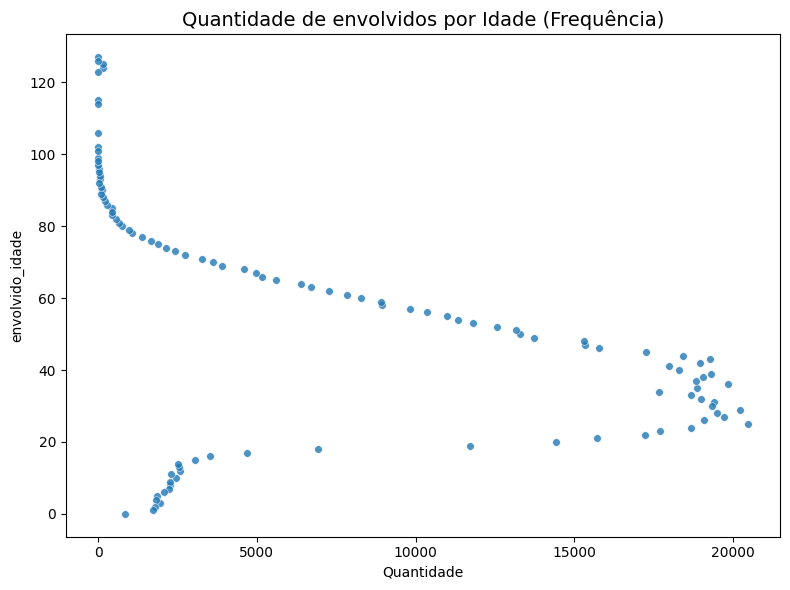

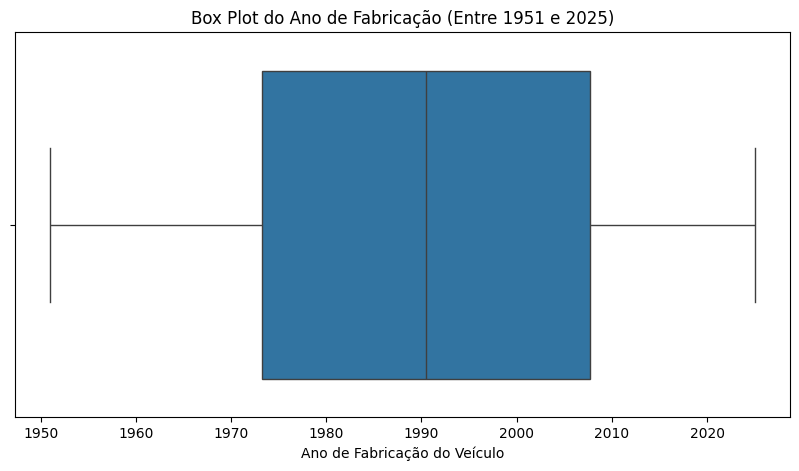

In [26]:
# Tratamento Idade
## Transformar idade > 200 em NaN
df.loc[df['envolvido_idade'] > 200, 'envolvido_idade'] = pd.NA


# Tratamento Ano de fabricação do veículo
## Transformar Ano Atual < Ano < 1920 em NaN 
ano_atual = datetime.now().year
df.loc[(df['veiculo_ano_fabricacao'] > ano_atual) | (df['veiculo_ano_fabricacao'] < 1920), 'veiculo_ano_fabricacao'] = pd.NA


# Mostra gráficos tratados
## Idade:
# Agrupa por idade, conta ocorrências e mostra em gráfico de dispersão
contagem_idade = df['envolvido_idade'].value_counts()
df_plot_frequencia = contagem_idade.reset_index()
df_plot_frequencia.columns = ['envolvido_idade', 'Quantidade']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot_frequencia,
    x='Quantidade',
    y='envolvido_idade',
    s=30,
    alpha=0.8
)
plt.title('Quantidade de envolvidos por Idade (Frequência)', fontsize=14)
plt.xlabel('Quantidade')
plt.ylabel('envolvido_idade')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

## Ano:

# Remove outliers baseados na marca (remove "Não Informado/Não Informado", "NA/NA", "NaN" e "Outros")
df_ano_tratado = df[~df['veiculo_marca_modelo'].isin(['Não Informado/Não Informado', 'NA/NA', 'NaN', 'Outros'])]
df_ano_tratado = df_ano_tratado[df_ano_tratado['veiculo_marca_modelo'].notna()]

# Agrupa por Ano de fabricação, conta IDs únicos de veículos e mostra em gráfico de Box
df_veiculos = df_ano_tratado.groupby('veiculo_ano_fabricacao')['veiculo_id'].nunique().reset_index()
df_veiculos.columns = ['veiculo_ano_fabricacao', 'Quantidade']
df_veiculos.set_index('veiculo_ano_fabricacao', inplace=True)

# Verifica valores mínimos e máximos para o título
ano_atual = datetime.now().year
ano_min = df_veiculos.index.min()
ano_max = df_veiculos.index.max()

# Criação do Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_veiculos.index)
plt.title(f'Box Plot do Ano de Fabricação (Entre {ano_min} e {ano_max})', fontsize=12)
plt.xlabel('Ano de Fabricação do Veículo')
plt.show()

## Resumo do Dataset tratado

In [27]:
# Resumo das colunas: dtype, não-nulos, nulos, % nulos, nunique e amostras
n = len(df)
summary = []
for col in df.columns:
    ser = df[col]
    non_null = int(ser.notna().sum())
    nulls = int(n - non_null)
    pct_null = (nulls / n) * 100 if n > 0 else 0
    try:
        nunique = int(ser.nunique(dropna=True))
    except Exception:
        nunique = pd.NA
    sample = ser.dropna().astype(str).head(5).tolist()
    summary.append({
        'column': col,
        'dtype': str(ser.dtype),
        'non_null': non_null,
        'nulls': nulls,
        'pct_null': round(pct_null, 2),
        'nunique': nunique,
        'sample_values': sample
    })

summary_df = pd.DataFrame(summary).set_index('column')

print('Resumo geral (ordenado por % de nulos):')
display(summary_df.sort_values('pct_null', ascending=False))

# Listar colunas criadas/convertidas
new = ['uso_solo', 'CondicaoMeteorologica',
       'gravidade', 'data_hora', 'dia_semana',
       'rodovia_numero', 'rodovia', 'data', 'periodo',
       'faixa_etaria_ano', 'faixa_etaria_classe',
       'hora', 'ano','localidade','regiao',
       'periodo_semana','ups','feridos',
       'mortos','latitude','longitude']
present_created = [c for c in new if c in df.columns]
print('\nNovas colunas criadas/convertidas:')
print(present_created)

# Mostrar as primeiras linhas das colunas criadas para inspeção rápida
if present_created:
    print('\nAmostra das colunas criadas/convertidas (primeiras 10 linhas):')
    display(df[present_created].head(10))

Resumo geral (ordenado por % de nulos):


,dtype,non_null,nulls,pct_null,nunique,sample_values
column,,,,,,
envolvido_idade,Int64,801873,179917,18.33,110,"[26, 34, 34, 55, 53]"
faixa_etaria_classe,string,802985,178805,18.21,4,"[Adulto, Adulto, Adulto, Adulto, Adulto]"
feridos_leves,Int64,886609,95181,9.69,2,"[0, 0, 0, 0, 0]"
mortos,Int64,886609,95181,9.69,2,"[1, 0, 0, 0, 0]"
id_envolvido,Int64,886609,95181,9.69,294539,"[1268971, 1268985, 1268985, 1269020, 1269028]"
feridos_graves,Int64,886609,95181,9.69,2,"[0, 0, 0, 0, 0]"
envolvido_tipo,object,886609,95181,9.69,5,"[Condutor, Condutor, Condutor, Condutor, Condu..."
estado_fisico,string,886609,95181,9.69,5,"[Óbito, Ileso, Ileso, Ileso, Ileso]"
envolvido_sexo,string,886609,95181,9.69,4,"[Masculino, Feminino, Feminino, Masculino, Mas..."



Novas colunas criadas/convertidas:
['uso_solo', 'gravidade', 'data_hora', 'dia_semana', 'rodovia_numero', 'rodovia', 'data', 'periodo', 'faixa_etaria_ano', 'faixa_etaria_classe', 'hora', 'ano', 'localidade', 'regiao', 'periodo_semana', 'ups', 'feridos', 'mortos', 'latitude', 'longitude']

Amostra das colunas criadas/convertidas (primeiras 10 linhas):


,uso_solo,gravidade,data_hora,dia_semana,rodovia_numero,rodovia,data,periodo,faixa_etaria_ano,faixa_etaria_classe,hora,ano,localidade,regiao,periodo_semana,ups,feridos,mortos,latitude,longitude
0,Urbano,Com morto,2024-01-01 00:05:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,20-29,Adulto,0,2024,Rio de Janeiro,Sudeste,Segunda à Sexta,13,0,1,-22.72936,-42.701125
1,Rural,Sem vítima,2024-01-01 00:05:00,Segunda-feira,153,BR-153,2024-01-01,Madrugada,30-39,Adulto,0,2024,Goiás,Centro-Oeste,Segunda à Sexta,1,0,0,-16.229185,-49.009797
2,Rural,Sem vítima,2024-01-01 00:05:00,Segunda-feira,153,BR-153,2024-01-01,Madrugada,30-39,Adulto,0,2024,Goiás,Centro-Oeste,Segunda à Sexta,1,0,0,-16.229185,-49.009797
3,Urbano,Sem vítima,2024-01-01 01:45:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,50-59,Adulto,1,2024,Espírito Santo,Sudeste,Segunda à Sexta,1,0,0,-20.172928,-40.267364
4,Rural,Sem vítima,2024-01-01 00:45:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,50-59,Adulto,0,2024,Santa Catarina,Sul,Segunda à Sexta,1,0,0,-26.83477,-48.706151
5,Rural,Com ferido,2024-01-01 00:45:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,30-39,Adulto,0,2024,Santa Catarina,Sul,Segunda à Sexta,4,1,0,-26.83477,-48.706151
6,Rural,Sem vítima,2024-01-01 00:45:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,50-59,Adulto,0,2024,Santa Catarina,Sul,Segunda à Sexta,1,0,0,-26.83477,-48.706151
7,Rural,Com ferido,2024-01-01 00:45:00,Segunda-feira,101,BR-101,2024-01-01,Madrugada,30-39,Adulto,0,2024,Santa Catarina,Sul,Segunda à Sexta,4,1,0,-26.83477,-48.706151
8,Urbano,Sem vítima,2024-01-01 01:45:00,Segunda-feira,116,BR-116,2024-01-01,Madrugada,0-9,Criança,1,2024,Rio Grande do Sul,Sul,Segunda à Sexta,1,0,0,-29.669385,-51.143047
9,Urbano,Sem vítima,2024-01-01 01:45:00,Segunda-feira,116,BR-116,2024-01-01,Madrugada,0-9,Criança,1,2024,Rio Grande do Sul,Sul,Segunda à Sexta,1,0,0,-29.669385,-51.143047


### Descrição estatística das colunas numéricas

In [28]:
df[['data', 'horario', 'envolvido_idade', 'veiculo_ano_fabricacao', 'quilometro', 'latitude', 'longitude', 'ilesos', 'feridos_leves', 'feridos_graves', 'feridos', 'mortos', 'ups', 'ano', 'hora']].describe()

,envolvido_idade,veiculo_ano_fabricacao,quilometro,latitude,longitude,ilesos,feridos_leves,feridos_graves,feridos,mortos,ups,ano,hora
count,801873.0,899199.0,979475.0,981790.0,981790.0,886609.0,886609.0,886609.0,981790.0,886609.0,981790.0,981790.0,981790.0
mean,38.959351,2013.725756,275.940057,-17.967304,-47.143976,0.410944,0.341142,0.127303,0.423031,0.054434,2.85898,2024.385597,12.860511
std,15.590693,8.110982,235.148954,7.887027,6.46389,0.492005,0.474093,0.333312,0.494041,0.226873,2.725823,0.486736,6.032596
min,0.0,1951.0,0.0,-33.689326,-72.656072,0.0,0.0,0.0,0.0,0.0,1.0,2024.0,0.0
25%,27.0,2009.0,84.0,-24.82179,-51.134128,0.0,0.0,0.0,0.0,0.0,1.0,2024.0,8.0
50%,38.0,2014.0,213.0,-19.78496,-47.988753,0.0,0.0,0.0,0.0,0.0,1.0,2024.0,14.0
75%,49.0,2020.0,427.0,-11.361209,-42.789004,1.0,1.0,0.0,1.0,0.0,4.0,2025.0,18.0
max,127.0,2025.0,1470.0,4.461419,-32.406822,1.0,1.0,1.0,1.0,1.0,13.0,2025.0,23.0


## Exportar o dataset tratado

In [ ]:
df.to_csv('../silver/etl/data/sinistros_tratado.csv', index=False, sep=';', encoding='latin1', quotechar='"')